In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# Define dataset directories
dataset_dir = "../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop/"
gt_dir = "../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop_segmentation/"  # Ground truth masks


In [11]:
# Get image files
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(".jpg")]

In [22]:
# ================= Segmentation Methods =================
def threshold_segmentation(image):
    """Segment mask using Otsu's thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def region_growing_segmentation(image, seed=None, threshold=10):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if seed is None:
        seed = (image.shape[0] // 2, image.shape[1] // 2)

    height, width = image.shape
    mask = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)

    seed_value = image[seed]
    stack = [seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True

        if abs(int(image[x, y]) - int(seed_value)) < threshold:
            mask[x, y] = 255  

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny]:
                    stack.append((nx, ny))

    return mask

def edge_contour_segmentation(image):
    """Segment mask using Canny edge detection + contour filling."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Edge detection
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    return mask

In [23]:
# ================= Evaluation Metrics =================
def compute_metrics(pred, gt):
    """Compute IoU, Dice, and Accuracy for segmentation masks."""
    if pred.shape != gt.shape:
        print(f"Warning: Shape mismatch! Resizing ground truth from {gt.shape} to {pred.shape}")
        gt = cv2.resize(gt, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred = (pred > 128).astype(np.uint8)
    gt = (gt > 128).astype(np.uint8)

    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    iou = intersection / union if union != 0 else 0
    
    dice = (2 * intersection) / (np.sum(pred) + np.sum(gt)) if (np.sum(pred) + np.sum(gt)) != 0 else 0
    
    accuracy = np.sum(pred == gt) / gt.size
    
    return iou, accuracy, dice


[ WARN:0@1338.185] global loadsave.cpp:268 findDecoder imread_('../VR_Project1_AnukritiSingh_MS2024504/MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity


Error: Ground truth mask is None for 000601_1.jpg


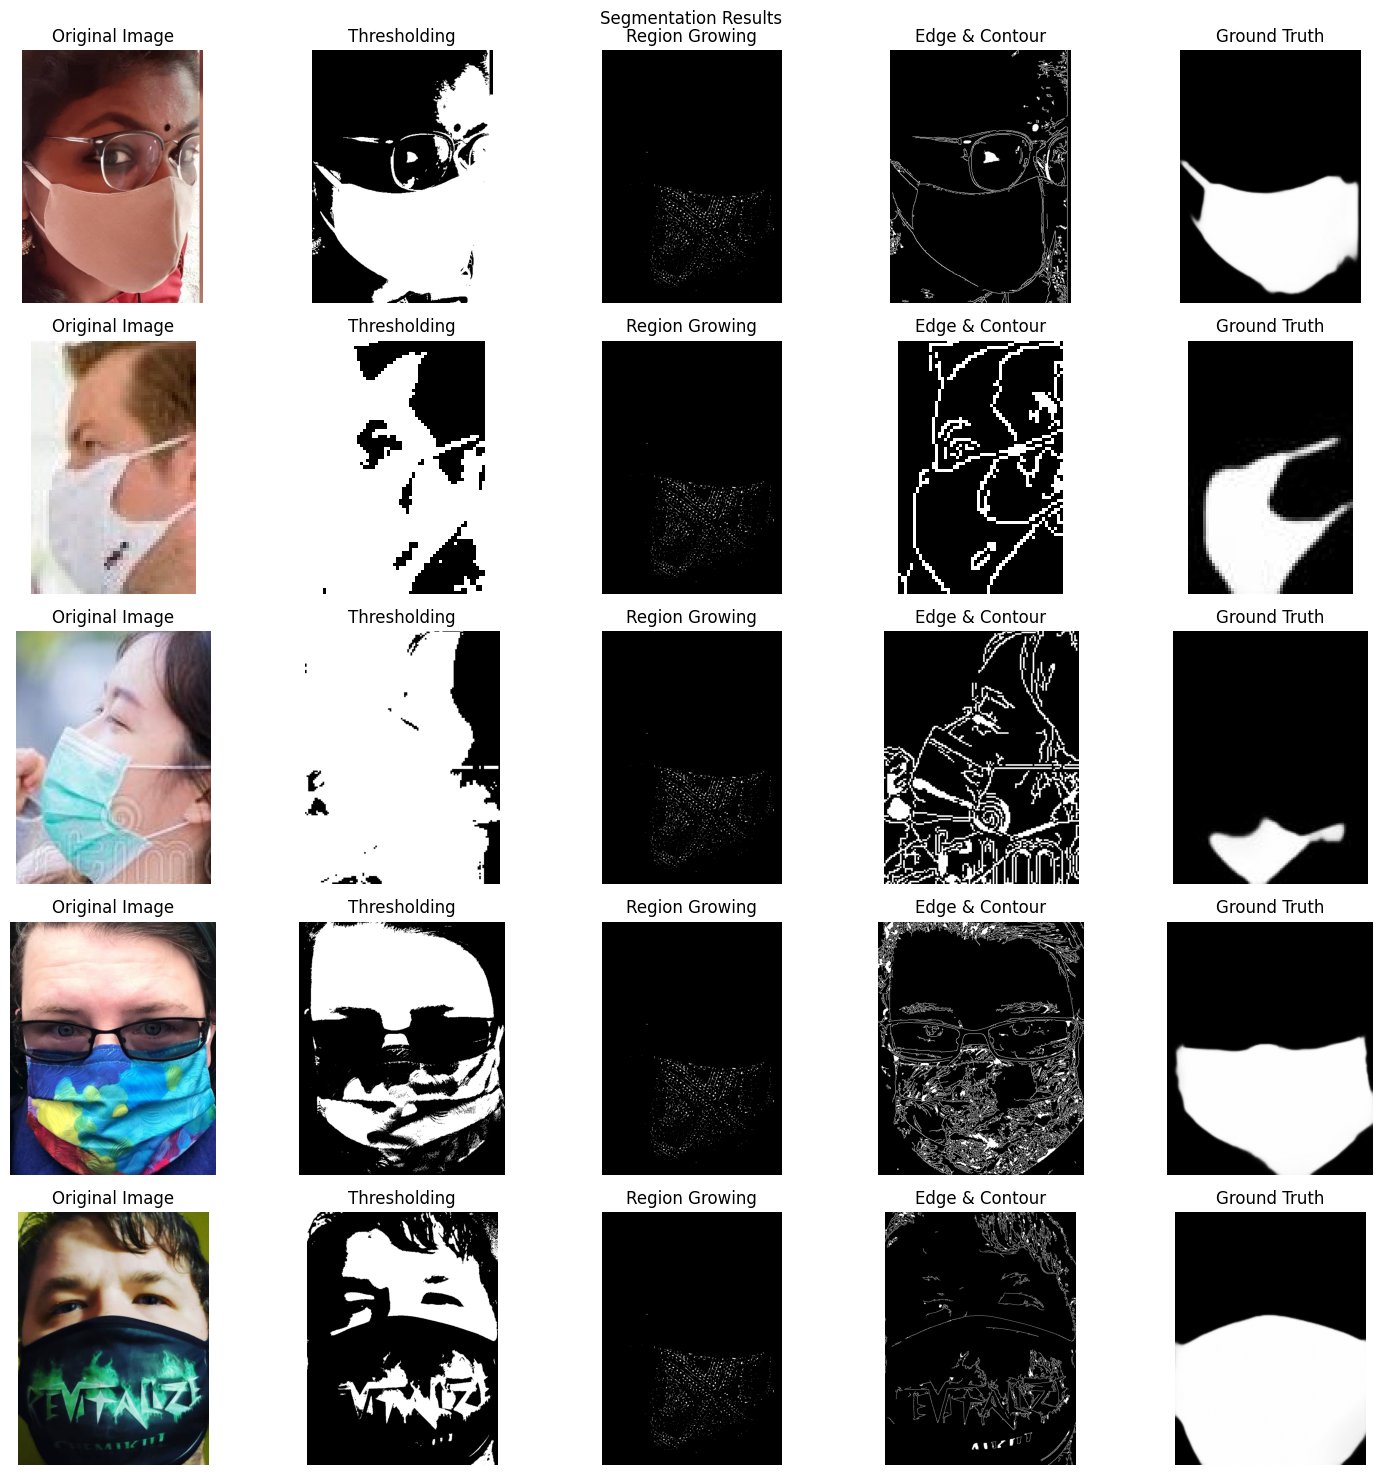

In [24]:
# ================= Processing Images =================
iou_scores, dice_scores, acc_scores = [], [], []
display_samples = 5  # Number of images to display

fig, axes = plt.subplots(display_samples, 5, figsize=(15, 15))
fig.suptitle("Segmentation Results")

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(dataset_dir, img_file)
    gt_path = os.path.join(gt_dir, img_file)  # Assuming ground truth is PNG

    image = cv2.imread(img_path)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    # Apply segmentation methods
    mask_thresh = threshold_segmentation(image)
    mask_region = region_growing_segmentation(image)
    mask_contour = edge_contour_segmentation(image)
    if gt_mask is None:
        print(f"Error: Ground truth mask is None for {img_file}")
        continue  # Skip this image to prevent errors

    # Compute metrics
    iou_t, dice_t, acc_t = compute_metrics(mask_thresh, gt_mask)
    iou_c, dice_c, acc_c = compute_metrics(mask_region, gt_mask)
    iou_e, dice_e, acc_e = compute_metrics(mask_contour, gt_mask)

    iou_scores.append((iou_t, iou_c, iou_e))
    dice_scores.append((dice_t, dice_c, dice_e))
    acc_scores.append((acc_t, acc_c, acc_e))

    # Display results for first 'display_samples' images
    if idx < display_samples:
        axes[idx, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title("Original Image")

        axes[idx, 1].imshow(mask_thresh, cmap="gray")
        axes[idx, 1].set_title("Thresholding")

        axes[idx, 2].imshow(mask_color, cmap="gray")
        axes[idx, 2].set_title("Region Growing")

        axes[idx, 3].imshow(mask_contour, cmap="gray")
        axes[idx, 3].set_title("Edge & Contour")

        axes[idx, 4].imshow(gt_mask, cmap="gray")
        axes[idx, 4].set_title("Ground Truth")

        for ax in axes[idx]:
            ax.axis("off")

plt.tight_layout()
plt.show()